 In order to first evaluate the bhdsgan I will use the following procedure:
 1. Sample from a truncated normal distribution with high variance --> gan should perform poorly
 2. Train gan on sampled data
 3. Generate new data and estimate density
 4. Compare actual and estimated density
 5. Sample from a truncated normal distribution with low variance --> gan should perform quite well
 6.Train gan on sampled data
 7. Generate new data and estimate density
 8. Compare actual and estimated density

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from time import time
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import seaborn as sns

from bhsgan import GeneratorBhsSim, DiscriminatorBhsSim
from wgan import GeneratorWassersteinSim, DiscriminatorWassersteinSim
from trainer import TrainingParams, Trainer, get_dis_loss_bhs, get_gen_loss_bhs
from utils import get_device, get_noise
from dataset import SampleDataset

torch.set_default_dtype(torch.float64)

## sample from truncated normal distributions

In [5]:
# sample from truncated beta distributions
a_low = 2
b_low = 5
a_high = 2
b_high = 2


C:\Users\lachlinu\AppData\Local\Temp\ipykernel_20968\2406008146.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(beta_sample_high, bw=0.5)
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

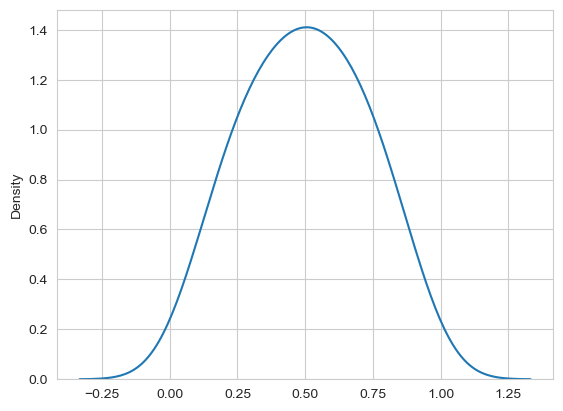

In [6]:
beta_sample_high = np.random.beta(a_high, b_high, 10000)
sns.set_style('whitegrid')
sns.kdeplot(beta_sample_high, bw=0.5)

C:\Users\lachlinu\AppData\Local\Temp\ipykernel_20968\3732047866.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(beta_sample_low, bw=0.5)
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

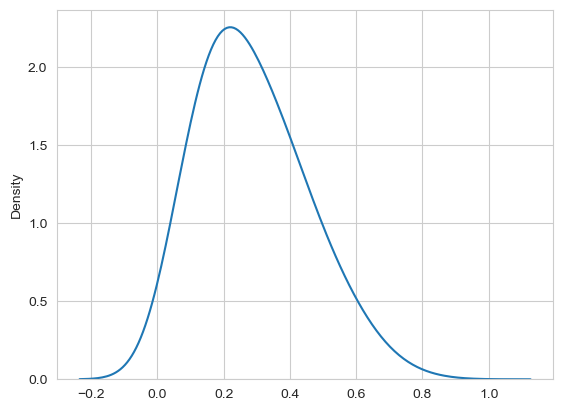

In [7]:
beta_sample_low = np.random.beta(a_low, b_low, 10000)
sns.set_style('whitegrid')
sns.kdeplot(beta_sample_low, bw=0.5)

In [8]:
training_set_high = SampleDataset(beta_sample_high)
training_set_low = SampleDataset(beta_sample_low)
#training_set_high = SampleDataset(np.random.normal(expected_value, standard_deviation_high, 10000))
#training_set_low = SampleDataset(np.random.normal(expected_value, standard_deviation_low, 10000))

In [9]:
np.mean(training_set_low)

0.28564552916240116

In [10]:
np.std(training_set_low)

0.1583228739365111

## Train GAN on both samples

In [11]:
training_params = TrainingParams(lr=0.0001, num_epochs=10, num_dis_updates=5, beta_1=0.5, batch_size=20)

# get device to train on
device = get_device()

In [13]:
# Create the dataloaders
batch_size = 20
dataloader_high = torch.utils.data.DataLoader(training_set_high, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
dataloader_low = torch.utils.data.DataLoader(training_set_low, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [14]:
# initialize nets
generator_high = GeneratorBhsSim()
discriminator_high = DiscriminatorBhsSim()
generator_low = GeneratorBhsSim()
discriminator_low = DiscriminatorBhsSim()

In [15]:
# init Trainer
trainer_high = Trainer(training_params, generator_high, discriminator_high)
trainer_low = Trainer(training_params, generator_low, discriminator_low)

### Train on high variance samples

In [16]:
# training loop
trained_bhs_high = trainer_high.train_gan(dataloader_high, get_dis_loss_bhs, get_gen_loss_bhs, False)

Epoch 0 training... done, took 2.2 seconds.
Epoch 1 training... done, took 1.9 seconds.
Epoch 2 training... done, took 1.9 seconds.
Epoch 3 training... done, took 1.9 seconds.
Epoch 4 training... done, took 2.1 seconds.
Epoch 5 training... done, took 2.7 seconds.
Epoch 6 training... done, took 2.0 seconds.
Epoch 7 training... done, took 2.0 seconds.
Epoch 8 training... done, took 2.0 seconds.
Epoch 9 training... done, took 2.0 seconds.


In [18]:
test_noise = get_noise(1000, 1)

In [19]:
generated_data = trained_bhs_high.generator(test_noise)
generated_sample = torch.reshape(generated_data, (1, 1000)).detach().numpy().ravel()

C:\Users\lachlinu\AppData\Local\Temp\ipykernel_20968\4019914335.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(torch.reshape(test_noise, (1, 1000)).detach().numpy().ravel(), bw=0.5)
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

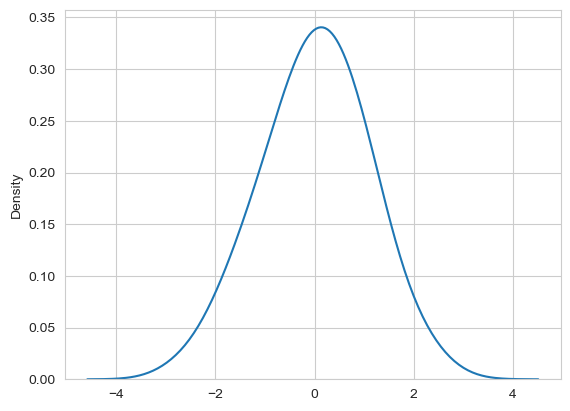

In [20]:
# plot test noise
sns.set_style('whitegrid')
sns.kdeplot(torch.reshape(test_noise, (1, 1000)).detach().numpy().ravel(), bw=0.5)

C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

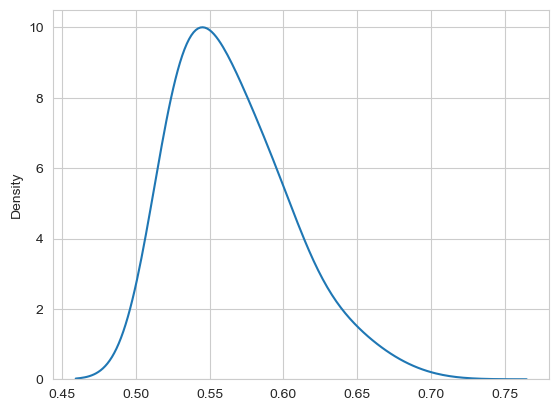

In [29]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample, bw_method=0.5)

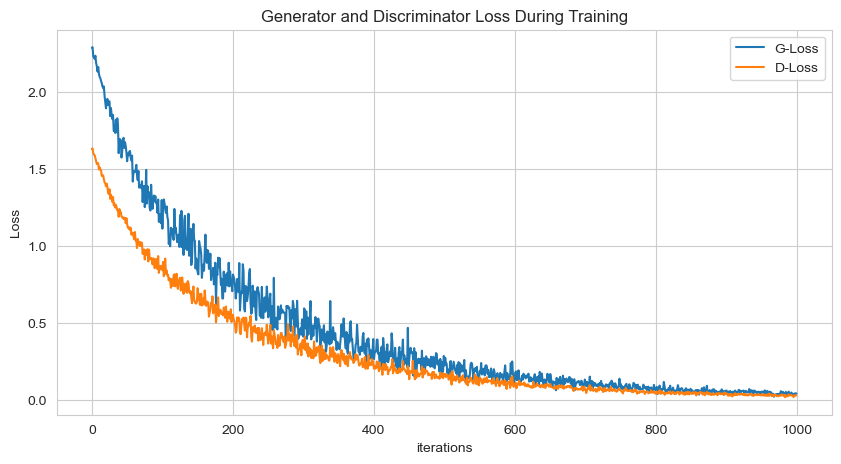

In [22]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trained_bhs_high.generator_losses,label="G-Loss")
plt.plot(trained_bhs_high.discriminator_losses,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# check mean and varaince of generated data
np.mean(generated_sample)

0.5653261251561128

In [24]:
np.std(generated_sample)

0.03753924083985033

### Train on low variance samples

In [25]:
# training loop
trained_bhs_low = trainer_low.train_gan(dataloader_low, get_dis_loss_bhs, get_gen_loss_bhs, False)

Epoch 0 training... done, took 1.9 seconds.
Epoch 1 training... done, took 1.9 seconds.
Epoch 2 training... done, took 1.9 seconds.
Epoch 3 training... done, took 2.0 seconds.
Epoch 4 training... done, took 1.9 seconds.
Epoch 5 training... done, took 1.9 seconds.
Epoch 6 training... done, took 1.9 seconds.
Epoch 7 training... done, took 2.0 seconds.
Epoch 8 training... done, took 1.9 seconds.
Epoch 9 training... done, took 1.9 seconds.


In [26]:
generated_data_low = trained_bhs_low.generator(test_noise)
generated_sample_low = torch.reshape(generated_data_low, (1, 1000)).detach().numpy().ravel()

C:\Users\lachlinu\AppData\Local\Temp\ipykernel_20968\4212569465.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample_low, bw=0.5)
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lachlinu\AppData\Local\anaconda3\envs\Torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

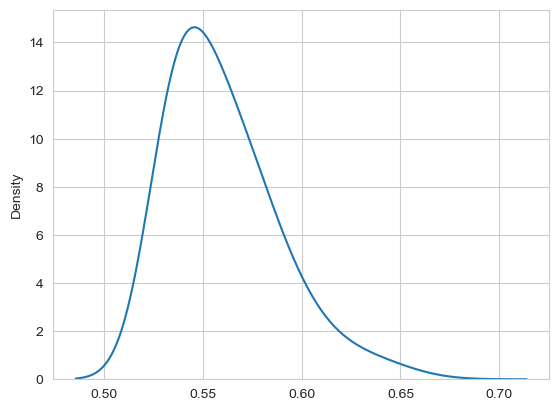

In [27]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample_low, bw=0.5)

NameError: name 'generator_losses_low' is not defined

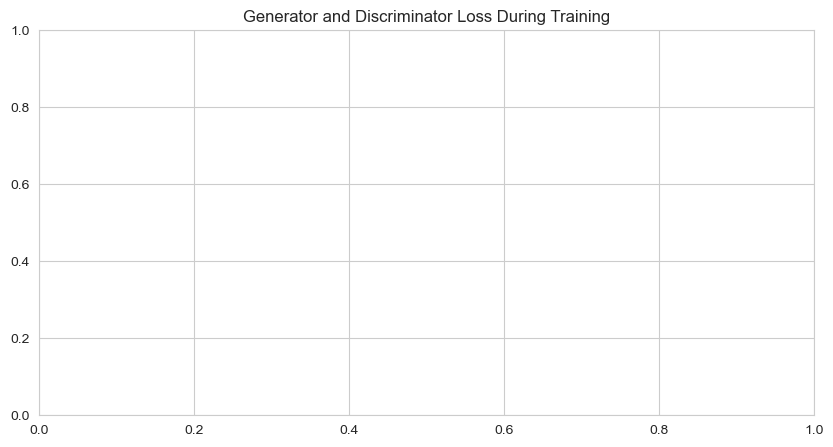

In [28]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses_low,label="G-Loss")
plt.plot(discriminator_losses_low,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [175]:
# check mean and varaince of generated data
np.mean(generated_sample)

0.47495445150671856

In [176]:
np.std(generated_sample)

0.04059958227132889

## Now I train a Wasserstein GAN on the low variance second task as well

In [177]:
dataloader_wasserstein = torch.utils.data.DataLoader(training_set_low, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
generator_wasserstein = GeneratorWassersteinSim()
discriminator_wasserstein = DiscriminatorWassersteinSim()
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein)

In [178]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader_wasserstein, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True)

Epoch 0 training... done, took 4.8 seconds.
Epoch 1 training... done, took 4.5 seconds.
Epoch 2 training... done, took 4.6 seconds.
Epoch 3 training... done, took 4.6 seconds.
Epoch 4 training... done, took 5.0 seconds.
Epoch 5 training... done, took 7.7 seconds.
Epoch 6 training... done, took 5.1 seconds.
Epoch 7 training... done, took 6.4 seconds.
Epoch 8 training... done, took 6.6 seconds.
Epoch 9 training... done, took 4.9 seconds.


In [180]:
generated_data_wasserstein = trained_wgan.generator(test_noise)
generated_sample_wasserstein = torch.reshape(generated_data_wasserstein, (1, 1000)).detach().numpy().ravel()

C:\Users\fottneal\AppData\Local\Temp\ipykernel_11492\2127257394.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(generated_sample_wasserstein, bw=0.5)


<AxesSubplot:ylabel='Density'>

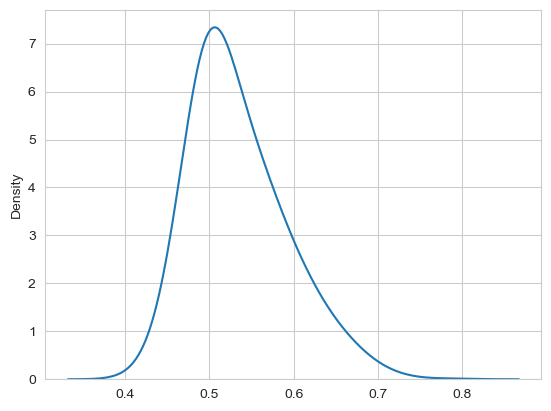

In [181]:
# plot resulting density
sns.set_style('whitegrid')
sns.kdeplot(generated_sample_wasserstein, bw=0.5)

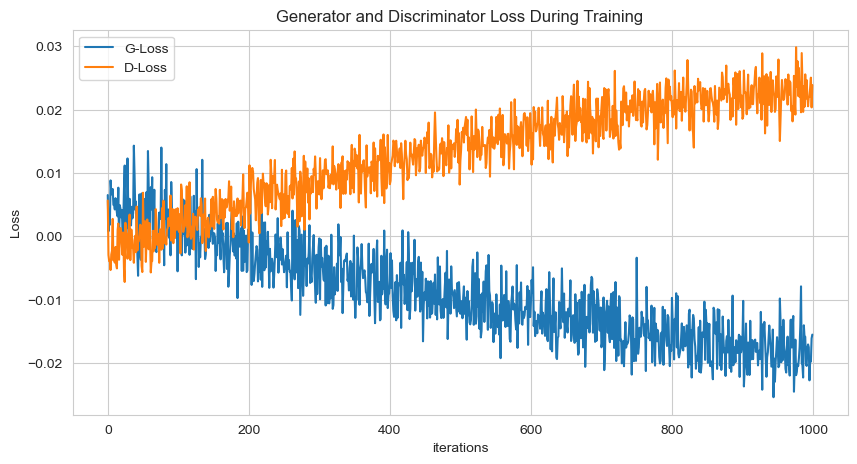

In [182]:
# plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses_wasserstein,label="G-Loss")
plt.plot(discriminator_losses_wasserstein,label="D-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# check mean and varaince of generated data
np.mean(generated_sample_wasserstein)

In [ ]:
np.std(generated_sample_wasserstein)